# Quora Insincere Questions Classification
The [Quora Insincere Questions Classification](https://www.kaggle.com/c/quora-insincere-questions-classification) Kaggle challenge tasks competitors to classify questions on the question asking website Quora as insincere or sincere. 

In this notebook I compare some different pre-processing alternatives as input to FastText's classifier.

# Inspect the data
I will not perform a through analysis of the dataset, but it is useful to get a basic understanding of what the data looks like.

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('data/train.csv')

In [3]:
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
print("There are %d questions in the data set" % len(train_df))

There are 1306122 questions in the data set


In [5]:
print("%.2f%% of the questions are insincere" % (100 * train_df['target'].sum() / len(train_df)))

6.19% of the questions are insincere


The data set contains over 1.3 million questions, which is quite large. It is also very imbalanced, with just over 6% of all questions being labeled insincere.

# Tokenization
I will not evaluate different tokenization methods, and will instead opt to use the standard spacy tokenizer.

In [6]:
from spacy.lang.en import English

In [7]:
nlp = English()

In [8]:
%%time
train_df['doc'] = train_df['question_text'].apply(nlp)

Wall time: 12min 59s


It sure takes a while to process all the text.

In [9]:
train_df['tokens'] = train_df['doc'].apply(len)

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

%matplotlib inline

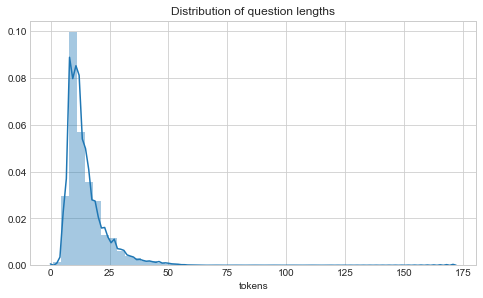

In [11]:
f, ax = plt.subplots(figsize=(8, 4.5))
sns.distplot(train_df['tokens'], ax=ax)
ax.set_title('Distribution of question lengths')

Most questions are less than 25 tokens, but there is a long tail of longer questions. The longest question is about 175 tokens long.

In [12]:
print("There are %d tokens in total" % train_df['tokens'].sum())

There are 19020651 tokens in total


19 million tokens in the training set!

# Set aside validation set
Before I start peeking at what words are in the training data I will set aside 10% of the questions as validation set.

In [13]:
from sklearn.model_selection import train_test_split

In [29]:
import numpy as np

In [15]:
train_idx, val_idx = train_test_split(np.arange(len(train_df)), stratify = train_df['target'], random_state = 1, test_size = .1)

In [16]:
val_df = train_df.iloc[val_idx]

In [17]:
train_df = train_df.iloc[train_idx]

In [18]:
print("%d training samples and %d validation samples."  % (len(train_df), len(val_df)))

1175509 training samples and 130613 validation samples.


# Construct dictionaries
I will be constructing three dictionaries right of the bat. They will be constructed based on:
* Un-processed words
* Lowercased words
* Lemmatized and lowercased words

In [19]:
def aggregate_vocab(vocab, doc, processing = "none"):
    for tok in doc:
        if processing == "none":
            word = tok.text
        elif processing == "lower":
            word = tok.text.lower()
        elif processing == "lemma":
            word = tok.lemma_.lower()
        
        try:
            vocab[word] += 1
        except KeyError:
            vocab[word] = 1
    
    return vocab
        

In [20]:
vocab_no_processing = {}
vocab_lower = {}
vocab_lemma = {}

In [21]:
from tqdm import tqdm_notebook

In [22]:
%%time
for doc in tqdm_notebook(train_df.loc[:,'doc']):
    vocab_no_processing = aggregate_vocab(vocab_no_processing, doc)
    vocab_lower = aggregate_vocab(vocab_lower, doc, processing = "lower")
    vocab_lemma = aggregate_vocab(vocab_lemma, doc, processing = "lemma")

A Jupyter Widget


Wall time: 4min 19s


In [23]:
n_tokens = train_df['tokens'].sum()

In [24]:
print("The training set contains %d tokens\n" % n_tokens)
print("There are %d unique un-processed tokens" % len(vocab_no_processing))
print("There are %d unique lower case tokens" % len(vocab_lower))
print("There are %d unique lemmatized tokens" % len(vocab_lemma))

The training set contains 17118554 tokens

There are 246461 unique un-processed tokens
There are 206333 unique lower case tokens
There are 192767 unique lemmatized tokens


Let's plot the distribution of word occurences per word type in each dictionary.

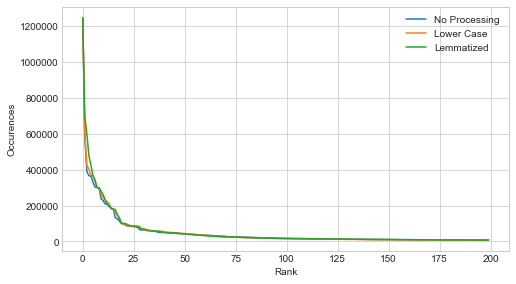

In [25]:
f, ax = plt.subplots(figsize=(8,4.5))
ax.set_xlabel('Rank')
ax.set_ylabel('Occurences')

for vocab in [vocab_no_processing, vocab_lower, vocab_lemma]:
    ax.plot(sorted(list(vocab.values()), reverse=True)[:200])
    
ax.legend(['No Processing', 'Lower Case', 'Lemmatized'])

All occurences have  couple of very common words, and a long tail of less frequent words. 

Very frequent words (stop words) such as "the", "it" etc. are often not that informative for classification, since they usually appear in all texts regardless of class. 
However, stop words can carry information about a persons style of writing. 
Some people might make heavier use of the word "I" for example.
It seems plausible that insincere questions might be written in another style compared to sincere questions, so I would like to try both with and without them.

Very infrequent words on the other hand carry little meaning for classification.
If a word appears very few times it is unlikely to carry information about the classes that generalise well. 
Also, such infrequent words often make up most of the vocabulary.
Therefore, I will prune any words that appear less than 50 times.

In [26]:
vocab_no_processing_pruned = dict([(word, count) for word, count in vocab_no_processing.items() if count >= 50])
vocab_lower_pruned = dict([(word, count) for word, count in vocab_lower.items() if count >= 50])
vocab_lemma_pruned = dict([(word, count) for word, count in vocab_lemma.items() if count >= 50])

In [27]:
print("There are %d unique un-processed tokens that appear 50 times or more" % len(vocab_no_processing_pruned))
print("There are %d unique lower case tokens that appear 50 times or more" % len(vocab_lower_pruned))
print("There are %d unique lemmatized tokens that appear 50 times or more" % len(vocab_lemma_pruned))

There are 14119 unique un-processed tokens that appear 50 times or more
There are 13486 unique lower case tokens that appear 50 times or more
There are 10670 unique lemmatized tokens that appear 50 times or more


In [28]:
doc = train_df.iloc[0]['doc']

In [29]:
for tok in doc:
    print(tok, tok.is_stop)

What False
are True
few True
things False
which True
should True
be True
done True
, False
if True
you True
live False
in True
India False
? False


# Generate documents for FastText
FastText operates on text files of specified formats, they should include class labels and text tokenized with spaces.
I will generate such files based on each of my vocabularies, with and without stop words.

In [75]:
def generate_row(vocab, doc, label, pre_processing = "none", remove_stop_words = False):
    row = "__label__%d " % label
    for tok in doc:
        if remove_stop_words and tok.is_stop:
            continue
        elif pre_processing == "none":
            word = tok.text
        elif pre_processing == "lower":
            word = tok.text.lower()
        elif pre_processing == "lemma":
            word = tok.lemma_.lower()
        
        if word in vocab:
            row += " %s" % word
    return row
        

In [76]:
text_no_processing = []
text_lower = []
text_lemma = []

text_no_processing_nostop = []
text_lower_nostop = []
text_lemma_nostop = []

In [77]:
%%time
for doc, label in tqdm_notebook(zip(train_df.iloc[:].loc[:,'doc'], train_df.iloc[:].loc[:, 'target'])):
    text_no_processing.append(generate_row(vocab_no_processing_pruned, doc, label))
    text_lower.append(generate_row(vocab_lower_pruned, doc, label, pre_processing="lower"))
    text_lemma.append(generate_row(vocab_lemma_pruned, doc, label, pre_processing="lemma"))
    
    text_no_processing_nostop.append(generate_row(vocab_no_processing_pruned, doc, label, remove_stop_words = True))
    text_lower_nostop.append(generate_row(vocab_lower_pruned, doc, label, pre_processing="lower", remove_stop_words = True))
    text_lemma_nostop.append(generate_row(vocab_lemma_pruned, doc, label, pre_processing="lemma", remove_stop_words = True))

A Jupyter Widget

Exception in thread Thread-8:
Traceback (most recent call last):
  File "C:\Users\Gustav\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Gustav\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 63, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\Gustav\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




Wall time: 4min 44s


In [79]:
val_text_no_processing = []
val_text_lower = []
val_text_lemma = []

val_text_no_processing_nostop = []
val_text_lower_nostop = []
val_text_lemma_nostop = []

In [80]:
%%time
for doc, label in tqdm_notebook(zip(val_df.iloc[:].loc[:,'doc'], val_df.iloc[:].loc[:, 'target'])):
    val_text_no_processing.append(generate_row(vocab_no_processing_pruned, doc, label))
    val_text_lower.append(generate_row(vocab_lower_pruned, doc, label, pre_processing="lower"))
    val_text_lemma.append(generate_row(vocab_lemma_pruned, doc, label, pre_processing="lemma"))
    
    val_text_no_processing_nostop.append(generate_row(vocab_no_processing_pruned, doc, label, remove_stop_words = True))
    val_text_lower_nostop.append(generate_row(vocab_lower_pruned, doc, label, pre_processing="lower", remove_stop_words = True))
    val_text_lemma_nostop.append(generate_row(vocab_lemma_pruned, doc, label, pre_processing="lemma", remove_stop_words = True))

A Jupyter Widget


Wall time: 31 s


In [94]:
def write_fasttext_file(rows, filename):
    with open('data/%s' % filename, 'w', encoding='utf-8') as f:
        for row in rows:
            f.write("%s\n" % row)

In [95]:
%%time
write_fasttext_file(text_no_processing, 'no_processing.train')
write_fasttext_file(text_no_processing_nostop, 'no_processing_nostop.train')
write_fasttext_file(text_lower, 'lower.train')
write_fasttext_file(text_lower_nostop, 'lower_nostop.train')
write_fasttext_file(text_lemma, 'lemma.train')
write_fasttext_file(text_lemma_nostop, 'lemma_nostop.train')

write_fasttext_file(val_text_no_processing, 'no_processing.val')
write_fasttext_file(val_text_no_processing_nostop, 'no_processing_nostop.val')
write_fasttext_file(val_text_lower, 'lower.val')
write_fasttext_file(val_text_lower_nostop, 'lower_nostop.val')
write_fasttext_file(val_text_lemma, 'lemma.val')
write_fasttext_file(val_text_lemma_nostop, 'lemma_nostop.val')

Wall time: 14.2 s


# Train Classifiers

In [3]:
import fasttext

In [4]:
import time

In [37]:
from sklearn.metrics import recall_score, precision_score, f1_score

In [52]:
import re

In [48]:
def read_texts_and_labels(filename):
    labels = []
    texts = []
    
    label_re = re.compile(r'__label__(\d)')
    text_re = re.compile(r'__label__\d  (.*)')

    with open('data/%s' % filename, encoding='utf-8') as f:
        for line in f:
            label = int(re.findall(label_re, line)[0])
            text = re.findall(text_re, line)[0]
            labels.append(label)
            texts.append(text)
    
    return texts, np.asarray(labels)

def train_and_eval(filename, grams=1, min_count = 50, dim = 10):
    print("-- %s --" % filename)
    print("Training Model")
    start_time = time.time()
    model = fasttext.supervised('data/%s.train' % filename, 'model', word_ngrams = grams, min_count = min_count, dim = dim)
    training_time = time.time() - start_time
    print("Training took %.2f s" % training_time)
    
    print("Evaluating Model")
    train_texts, train_labels = read_texts_and_labels('%s.train' % filename)
    val_texts, val_labels = read_texts_and_labels('%s.val' % filename)
    
    predictions_train = np.asarray([int(pred[0]) for pred in model.predict(train_texts)])
    predictions_val = np.asarray([int(pred[0]) for pred in model.predict(val_texts)])
    
    training_results = {
        'precision' : precision_score(train_labels, predictions_train),
        'recall' : recall_score(train_labels, predictions_train),
        'f1' : f1_score(train_labels, predictions_train)
    }
    
    val_results = {
        'precision' : precision_score(val_labels, predictions_val),
        'recall' : recall_score(val_labels, predictions_val),
        'f1' : f1_score(val_labels, predictions_val)
    }
    
    # Had trouble with fastexts built in test function, so I'm using sklearn instead
    print("\nTraining Set Performance:")
    print("Precision %.3f" % training_results['precision'])
    print("Recall %.3f" % training_results['recall'])
    print("F1 %.3f" % training_results['f1'])
    
    print("\nValidation Set Performance:")
    print("Precision %.3f" % val_results['precision'])
    print("Recall %.3f" % val_results['recall'])
    print("F1 %.3f\n" % val_results['f1'])
    
    return model, training_results, val_results, training_time

In [43]:
filenames = [
    'no_processing',
    'no_processing_nostop',
    'lower',
    'lower_nostop',
    'lemma',
    'lemma_nostop'
]

In [44]:
%%time
results = [train_and_eval(filename) for filename in filenames]

-- no_processing --
Training Model
Training took 13.51 s
Evaluating Model

Training Set Performance:
Precision 0.711
Recall 0.465
F1 0.562

Validation Set Performance:
Precision 0.682
Recall 0.441
F1 0.535
-- no_processing_nostop --
Training Model
Training took 10.24 s
Evaluating Model

Training Set Performance:
Precision 0.700
Recall 0.466
F1 0.560

Validation Set Performance:
Precision 0.671
Recall 0.441
F1 0.532
-- lower --
Training Model
Training took 12.90 s
Evaluating Model

Training Set Performance:
Precision 0.711
Recall 0.467
F1 0.563

Validation Set Performance:
Precision 0.684
Recall 0.443
F1 0.538
-- lower_nostop --
Training Model
Training took 9.50 s
Evaluating Model

Training Set Performance:
Precision 0.700
Recall 0.472
F1 0.564

Validation Set Performance:
Precision 0.667
Recall 0.445
F1 0.534
-- lemma --
Training Model
Training took 14.48 s
Evaluating Model

Training Set Performance:
Precision 0.698
Recall 0.457
F1 0.553

Validation Set Performance:
Precision 0.668
Rec

In [49]:
performance_list = [(name, res['precision'], res['recall'], res['f1'], time) for name, (_, _, res, time) in zip(filenames, results)]

In [50]:
performance_df = pd.DataFrame(data=performance_list, columns = ['Processing', 'Precision', 'Recall', 'F1', 'Training Time (s)'])

In [51]:
performance_df

,Processing,Precision,Recall,F1,Training Time (s)
0,no_processing,0.681653,0.440911,0.535467,13.507555
1,no_processing_nostop,0.671127,0.440663,0.532009,10.237433
2,lower,0.684120,0.443014,0.537780,12.897498
3,lower_nostop,0.667409,0.444994,0.533967,9.503349
4,lemma,0.667939,0.433115,0.525486,14.484185
5,lemma_nostop,0.660488,0.432125,0.522442,12.659390


In [54]:
measures = performance_df.columns[1:]

C:\Users\Gustav\Anaconda3\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


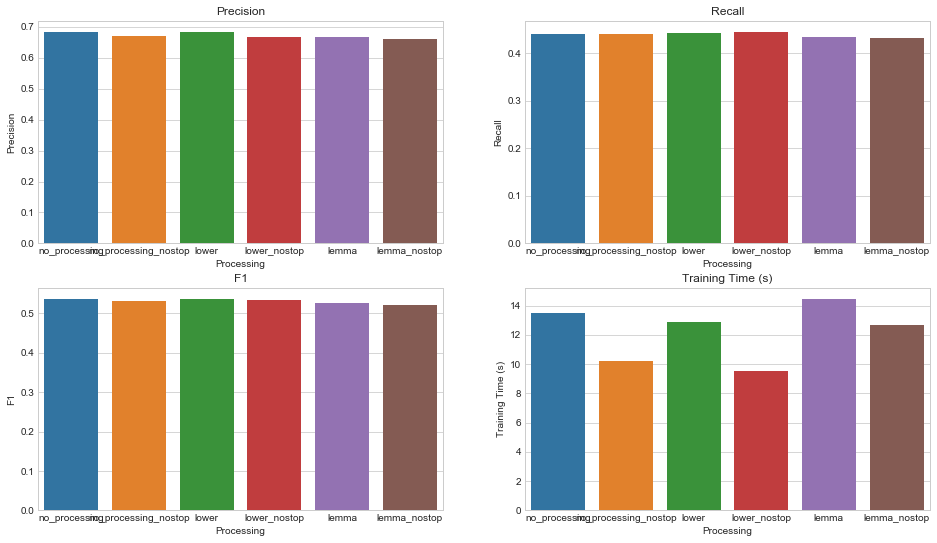

In [58]:
f, ax = plt.subplots(2, 2, figsize=(16,9))
ax = ax.flatten()

for i, measure in enumerate(measures):
    sns.barplot(x='Processing', y=measure, data = performance_df, ax=ax[i])
    ax[i].set_title(measure)

There are no huge differences in results between the pre-processing techniques. 
Lemmatization combined with removing stop words got the lowest f1 measure of 0.522.
The largest f1 measure of 0.538 was achieved with lowercase and keeping stop words.
The difference is very small.

The differences in training time are hardly relevant as they only differ by a couple of seconds. 